# Домашнее задание. Градиентный спуск

## Краткое напоминание
Рассматривается задача минимизации $f(x) \to \min\limits_{x \in \mathbb{R}^n}$
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k)
$$

## Задача 1. Убираем шум с фотографии (denoising).
Будем рассматривать изображение, как скалярную функцию от двух переменных (координаты $x$ и $y$):
$$
f(x,y): \mathbb{R}^d \to \mathbb{R} \;\;\;\;\;\; (d = n \times n)
$$

Мы нарисуем енотика, который есть у всех. Вы можете загрузить Ваше любимое изображение с помощью функции [`imread`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imread.html). Люди, выполнившие задание полностью смогут принять участие в конкурсе самых мемных картинок по мнению преподавателя.

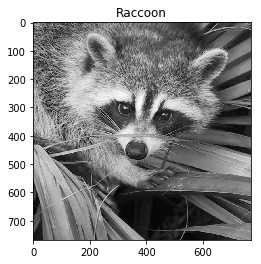

In [2]:
# Libraries
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np

# Uploading and normalizing the image of raccoon
enot = (misc.face(gray = True)/255)[:, -768:]

# Plotting
plt.imshow(enot, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')
plt.show()

Пошумим? Добавим двухмерный гауссов шум с нулевым средним и задаваемой дисперсией
$$
y = enot(x,y) + \mathcal{N}(0, \sigma)
$$

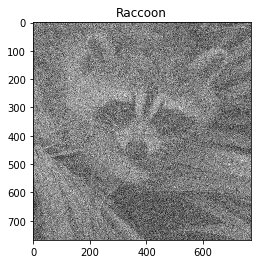

In [3]:
# Enot's size
n = enot.shape[1]

# Add some noise
sigma = 0.3
y = (enot + sigma*np.random.randn(n,n))

# Plotting
plt.imshow(y, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')
plt.show()

Задача заключается в том, как, имея только шумное изображение $y$, получить максимально близкое к исходному (как минимум, менее шумное). Наша задача будет формулироваться следующим образом: 

$$
\min_{x \in R^d} f(x) = \frac{1}{2} \|y-x\|^2 + \lambda J(x),
$$

где $J(x)$ - некоторая функция, которая характеризует шумность (зернистость) картинки. То есть, решая задачу оптимизации мы должны получить с одной стороны изображение, близкое к $y$, с другой стороны, как можно менее шумное. Остается один важный вопрос - *что из себя представляет функция $J(x)$?*

### Подход бедных студентов
В каждой точке изображения можно посчитать производную по двум координтам. Таким образом, если изображение это функция $enot(x, y): \mathbb{R}^d \to \mathbb{R}$, то её градиент - это функция $\nabla enot(x,y): \mathbb{R}^d \to \mathbb{R}^2$, представляющая в каждой точке вектор из двух компонент $\left( \dfrac{\partial \;enot}{\partial x}, \dfrac{\partial \;enot}{\partial y} \right)$. Полный набор по все точкам - тензор размера $n \times n \times 2$

Величина градиента в каждой точке может быть оценена как

$$
g(x_i, y_i) = \sqrt{\left(\dfrac{\partial \;enot}{\partial x} (x_i, y_i)\right)^2 + \left(\dfrac{\partial \;enot}{\partial y} (x_i, y_i)\right)^2}
$$

Тогда будем строить $J(x)$ следующим образом:
$$
J(x) = \sum\limits_{x_i,y_i} \left[g(x_i, y_i)^2 \right]
$$

Тогда он будет характеризовать некоторую кумулятивную величину изменения значения пикселя по всему изображению. [Метод конечных разностей](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D1%8B%D1%85_%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) поможет оценить величину частной производной. Для решения проблемы с граничными значениями можно, например, считать, что изображение циклично продолжается по сторонам (т.е. следующие столбец/ строка после последнего - это первый).
$$
\nabla enot(x_i, y_i) = \left(enot(x_{i+1}, y_{i}) - enot(x_{i}, y_{i}), enot(x_{i}, y_{i+1}) - enot(x_{i}, y_{i})  \right)
$$

In [4]:
import numpy as np

# Напишите функцию, которая принимает на вход черно-белое изображение nxn пикселей, а возвращает тензор размера nxnx2,
# содержащий частные производные в каждой точке, рассчитанный по методу конечных разностей.
def grad(x):
    return np.array([x - np.roll(x, shift=1, axis=i) for i in range(2)])

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает матрицу размера nxn,
# содержащую величину градиента в квадрате в каждой точке.
def grad_magnitude(x):
    g = grad(x)
    return g[0]**2 + g[1]**2

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def J(x):
    return np.sum(grad(x)**2) 

# Напишите функцию, которая считает функцию потерь. (она возвращает число)
def f(x, y, lambd):
    return np.sum((y-x)**2)/2 + lambd*J(x)


Для решения задачи методом градиентого спуска необходимо записать градиент целевой функции:
$$
\nabla f(x) = x-y + \lambda \nabla J(x)
$$
Вам предлагается самостоятельно предложить способ подсчета градиента функции $J(x)$. Заметим, что здесь есть широкий простор для творчества (начиная от аналитического вывода формулы и введения гессиана изображения, заканчивая, опять же, разностными схемами первого порядка). Поощрается Ваша интуиция и любое решение, подкрепленное убедительной мотивацией.

$$
\frac{\partial J}{\partial x_{\alpha \beta}} = \frac{\partial}{\partial x_{\alpha \beta}} \sum_i \sum_j \left[\left(g_{ij}^{(x)}\right)^2 + \left(g_{ij}^{(y)}\right)^2\right] = 2 \sum_i \sum_j \left[g_{ij}^{(x)}\frac{\partial g_{ij}^{(x)}}{\partial x_{\alpha \beta}} + g_{ij}^{(y)}\frac{\partial g_{ij}^{(y)}}{\partial x_{\alpha \beta}}\right]
$$

$$
g_{ij}^{(x)} = x_{i,j} - x_{i,j-1}, \quad \quad g_{ij}^{(y)} = x_{i,j} - x_{i-1,j}
$$

$$
\frac{\partial g_{ij}^{(x)}}{\partial x_{\alpha \beta}}  = \delta_{i, \alpha} \delta_{j, \beta} - \delta_{i, \alpha} \delta_{j-1, \beta}, \quad \quad \frac{\partial g_{ij}^{(y)}}{\partial x_{\alpha \beta}}  = \delta_{i, \alpha} \delta_{j, \beta} - \delta_{i-1, \alpha} \delta_{j, \beta}
$$

$$
\frac{\partial J}{\partial x_{\alpha \beta}} = g_{\alpha,\beta}^{(x)} - g_{\alpha,\beta+1}^{(x)} + g_{\alpha, \beta}^{(y)} - g_{\alpha+1, \beta}^{(y)}
$$

In [5]:
# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)

def div(x):
    g = x.copy()
    for i in range(2):
        g[i] -= np.roll(g[i], -1, axis=i)
    
    return (g[0] + g[1])

def dJ(x):
    return 2*div(grad(x))

# Напишите функцию, которая считает градиент функции f(x) (она возвращает массив nxn)
def df(x, y, lambd):
    return (x-y) + lambd*dJ(x)

Тогда градиентный спуск здесь будет выглядеть следующим образом:
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k), \;\;\;\;\; x_0 = y
$$

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

### Как можно оптимизировать (эвристика и прочие сомнительные вещи)

Считая функцию ошибок "ровной" можно попытаться поддерживать скорость продвижения к минимуму более-менее постоянной, увеличивая $\eta$ с номером шага, когда ничего не предвещает беды, и уменьшая в противном случае.

Метод с уменьшением градиента $\eta_k = \frac{\eta_0}{\sqrt{k}}$ показался странным, потому что тормозит и без того сходящийся спуск. Критерий остановки -- малость изменения функции. Градиент себя не очень стабильно ведёт.

Iteration: 70/500, f = 21446.5172795

Result: 21446.517279


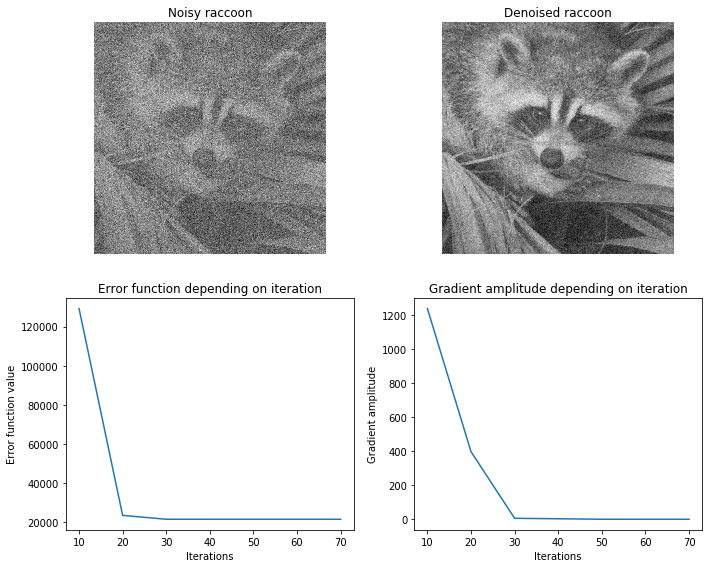

In [6]:
import sys

def gradient_descent(fun, x0, jac, args=(), mod='accel', max_it=500, epsilon=1e-6):    
    x = x0.copy()
    fs = []
    dfs = []
    its = []
    if mod == 'dynamic': 
        eta = 1e-1
    else:
        eta = 1/(1+4/epsilon)
        
    eta_k = eta
    f_k = 2*fun(x, *args)
    
    it = 0
    while it < max_it:
        if mod == 'dynamic': 
            eta_k = eta_k/np.sqrt(it+1)
        
        it += 1
        df_k = jac(x, *args)
        dx = -eta_k * df_k
        x += dx 
        old_f = f_k
        f_k = fun(x, *args)
        
        if mod == 'accel':
            if f_k < old_f:
                eta_k *= 2
            else:
                while f_k > old_f:
                    eta_k /= 2
                    dx /= 2
                    x -= dx
                    f_k = fun(x, *args)
                    it += 1
        
        if mod == 'accel' and np.abs(old_f - f_k) < epsilon:
            break
        elif np.linalg.norm(dx) < epsilon:
            break
        
        if not it % 10**1:
            sys.stderr.write('\rIteration: %d/%d, f = %f' % (it, max_it, f_k))
            sys.stderr.flush()
            fs.append(f_k)
            its.append(it)
            dfs.append(np.linalg.norm(df_k))  
    
    return x, its, fs, dfs

def denoise_GD_showcase(y, f, df, lambd):
    x, its, fs, dfs = gradient_descent(f, y, df, args=(y, lambd))
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    print('Result: %f' % fs[-1])
    axes[1, 0].set_title('Error function depending on iteration')
    axes[1, 0].set_xlabel('Iterations')
    axes[1, 0].set_ylabel('Error function value')
    axes[1, 0].plot(its, fs)

    axes[1, 1].set_title('Gradient amplitude depending on iteration')
    axes[1, 1].set_xlabel('Iterations')
    axes[1, 1].set_ylabel('Gradient amplitude')
    axes[1, 1].plot(its, dfs)

    axes[0, 0].imshow(y, cmap='gray')
    axes[0, 0].set_title('Noisy raccoon')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(x, cmap='gray')
    axes[0, 1].set_title('Denoised raccoon')
    axes[0, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
denoise_GD_showcase(y, f, df, 0.6)

### Как нужно оптимизировать (CG и накакой магии)

Optimization terminated successfully.
         Current function value: 21446.517277
         Iterations: 19
         Function evaluations: 42
         Gradient evaluations: 42


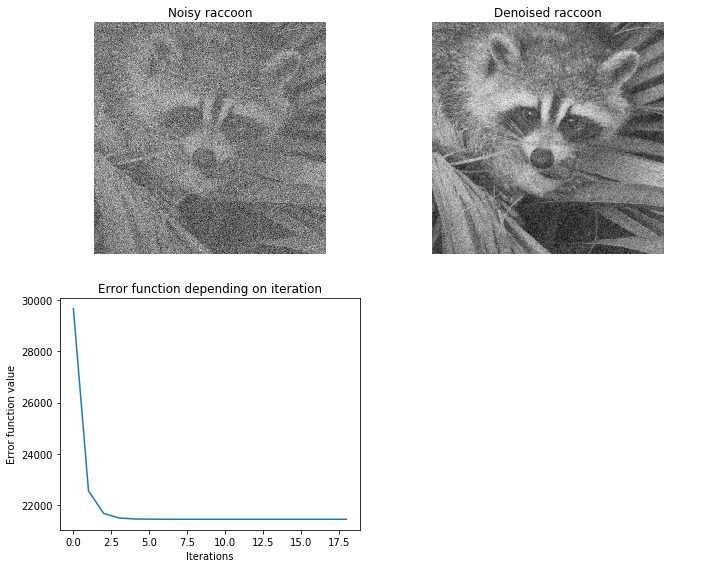

In [13]:
from scipy.optimize import minimize

def denoise_CG_showcase(y, f, df, lambd):
    def f_flat(x_f, y, lambd):
        x = x_f.reshape(y.shape)
        return f(x, y, lambd), df(x, y, lambd).flatten()

    def cb(x):
        fs.append(f(x.reshape(y.shape), y, lambd))
    
    x_f = y.flatten()

    fs = []
    res = minimize(f_flat, x_f, args=(y, lambd), method='CG', jac=True,
                   callback=cb, options={'disp':True})
    x = res.x.reshape(y.shape)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    axes[1, 0].set_title('Error function depending on iteration')
    axes[1, 0].set_xlabel('Iterations')
    axes[1, 0].set_ylabel('Error function value')
    axes[1, 0].plot(fs)

    axes[1, 1].axis('off')

    axes[0, 0].imshow(y, cmap='gray')
    axes[0, 0].set_title('Noisy raccoon')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(x, cmap='gray')
    axes[0, 1].set_title('Denoised raccoon')
    axes[0, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
denoise_CG_showcase(y, f, df, 0.6)

### Подход богатых студентов (Total Variation Denoising)
[Здесь](http://www.numerical-tours.com/matlab/optim_1_gradient_descent/) можно почитать мануал на [тему](https://en.wikipedia.org/wiki/Total_variation_denoising). Реализуйте функции $J(x)$ и $\nabla J(x)$ в этом подходе согласно мануалу.

In [10]:
# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def norm_eps(x, eps=1e-3):
    return np.sqrt(x[0]**2 + x[1]**2 + eps**2)

def J_tv(x):
    return np.sum(norm_eps(grad(x)))

# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ_tv(x):
    g = grad(x)
    return div(g/norm_eps(g))

def f_tv(x, y, lambd):
    return np.sum((y-x)**2)/2 + lambd*J_tv(x)

def df_tv(x, y, lambd):
    return (x-y) + lambd*dJ_tv(x)

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

Iteration: 500/500, f = 28003.005504

Result: 28003.005504


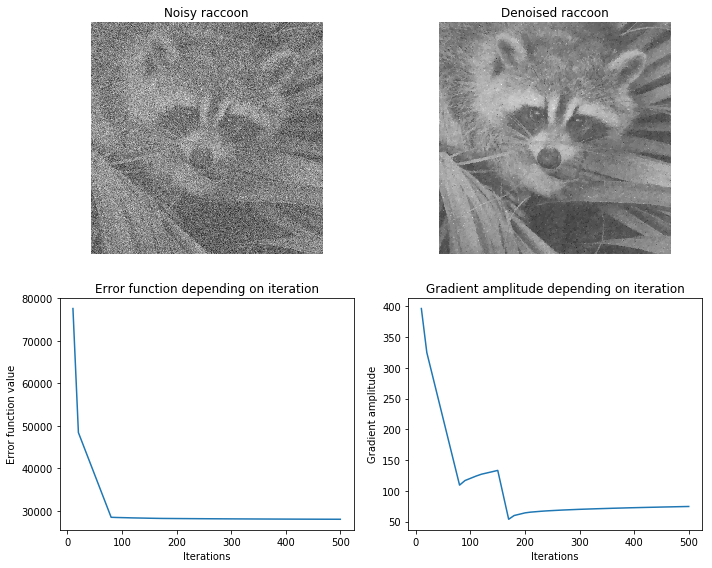

In [8]:
denoise_GD_showcase(y, f_tv, df_tv, 0.25)

Optimization terminated successfully.
         Current function value: 28034.873533
         Iterations: 487
         Function evaluations: 756
         Gradient evaluations: 755


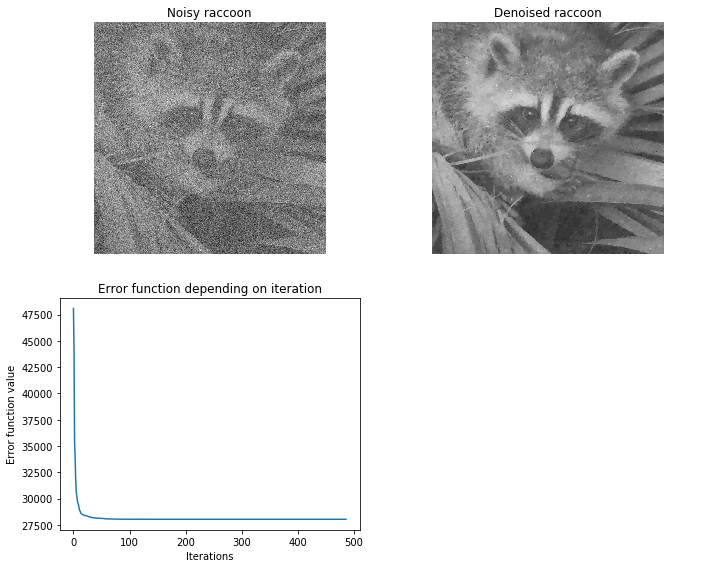

In [14]:
denoise_CG_showcase(y, f_tv, df_tv, 0.25)